In [2]:
%load_ext autoreload
%autoreload

import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import ptsa
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import *
from copy import copy
from scipy import stats
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/SWRrefactored/code/SWR_modules/')
from SWRmodule import *
from general import * #superVstack,findInd,findAinB
from power_functions import z_score, process_power, load_z_scored_power

base = '/home1/john/SWRrefactored'
sys.path.append(f'{base}/code/')

from load_data_numpy import load_data_np
from SWRmodule import triangleSmooth
# from comodulogram import remove_session_string, get_filtered_signal
# from fooof import FOOOF

import statsmodels.formula.api as smf
from scipy.signal import decimate, resample, hilbert, welch, spectrogram
from mne.time_frequency import tfr_array_morlet

# # Import the time & event model objects and Bands object to manage oscillation band definitions
# from specparam import SpectralTimeModel, SpectralTimeEventModel, Bands
# # Import helper utilities for simulating and plotting spectrograms
# from specparam.sim import sim_spectrogram
# from specparam.plts.spectra import plot_spectrogram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
np.logspace(np.log10(80),np.log10(178),10)

array([ 80.        ,  87.43437519,  95.55962457, 104.43995085,
       114.1455231 , 124.75303116, 136.34629167, 149.01691027,
       162.86500554, 178.        ])

In [10]:
# for now the plotting code only works with one region at a time
region_name = ['HPC'] # ['ENT'] # ['AMY']
subregion = ['ca1'] #['ca1'] # can use [''] to select ALL subregions
task = 'catFR1' # 'catFR1'
savePath = f'{base}/figures/'

# 1 for encoding, 0 for recall
encoding_mode_arr = [1] #[0,1] 
freq_range_str_arr = [[33.5,75],[80,120]] #,[2,4],[7,9]] # [80,178]
# these were selecetd to avoid 60 and 120 Hz using np.logspace(np.log10(30),np.log10(75),10)

# define frequency ranges
buffer = 2000 # time in ms to buffer trials (for Morlet)

plot_error_bars = True

fs = 500 # sampling rate for raw data and ripples from createEventsForDF.py

In [11]:
# np.shape(dd_trials['ripple'])
# np.shape(dd_trials['raw'])
# dd_trials.keys()
# np.unique(dd_trials['elec_labels'])

In [12]:
for encoding_mode in encoding_mode_arr:

    dd_trials = load_data_np(encoding_mode,task,
        region_name=region_name, train_only=False, subregion=subregion)
    
    region_str = region_name[0]
    subregion_str = subregion[0]
    
    clust = dd_trials['clust_int']
    notclust_idxs = np.argwhere(clust<0).squeeze()
    clust_idxs = np.argwhere(clust>0).squeeze()
    
    if encoding_mode:
        saveName = 'encoding_'
        recall_str = ''
        time = np.linspace(-0.7, 2.3, 150)
        correct = dd_trials['correct']
        incorrect_idxs = np.argwhere(correct==0).squeeze()
        start_cutoff = 300 # times (in s) relative to word_on 
        end_cutoff = 1300 
        
    else:
        saveName = 'recall_'
        recall_str = '_recall'
        time = np.linspace(-2, 2, 200)
        start_cutoff = -1000
        end_cutoff = 0      
        
    # convert time ranges to samples
    sr_factor = 1000/fs
    # data taken is from -1.7 to 3.3 s from word_on so account for that by adding 1700 ms
    start_cutoff = 0
    end_cutoff = 2500 # just take the whole range of data to better estimate Morlet
#     start_cutoff = int((1700+start_cutoff-buffer)/sr_factor) # this comes to 0:2500 anyway
#     end_cutoff = int((1700+end_cutoff+buffer)/sr_factor)     # ...so just index in time from here
    
    
    print("Generating figures for run_mode: ", encoding_mode)
    # starts with high and moves to low
    power_z = load_z_scored_power(dd_trials, freq_range_str_arr, encoding_mode,fs,start_cutoff, end_cutoff)
        
    # note that output is 50 Hz (20 ms bins) since started 500 hz and decimated 10x
    if len(subregion[0]) > 0:
        subregion_str = f'_{subregion[0]}'
    else:
        subregion_str = ''           

a=1;            

Loading data
LOADING DATA FROM: HPC FOR EXPERIMENT catFR1


/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
elec_by_elec_correlation
order: C


/home1/john/SWRrefactored/code/SWR_modules/load_data.py:433: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dd_trials[key] = np.asarray(val)


Generating figures for run_mode:  1


In [13]:
dd_trials.keys()
np.shape(dd_trials['ripple'])
np.shape(dd_trials['raw'])

np.shape(power_z)
freq_range_str_arr

unique_subs = np.unique(dd_trials['subj'])
unique_subs

dict_keys(['ripple', 'clust', 'correct', 'position', 'list_num', 'subj', 'sess', 'elec_names', 'elec_labels', 'serial_pos', 'raw', 'elec_by_elec_correlation', 'trial_by_trial_correlation', 'elec_ripple_rate_array', 'category_array', 'clust_int'])

(29208, 1500)

(29208, 2500)

(2, 29208, 250)

[[33.5, 75], [80, 120]]

array(['R1065J', 'R1108J', 'R1112M', 'R1486J', 'R1501J', 'R1525J'],
      dtype='<U6')

In [75]:
gamma_sd_thresh = 1.5

# select a patient
patient_idx = -1
if patient_idx >-1: 
    sub_idxs = dd_trials['subj']==unique_subs[patient_idx]
else:
    sub_idxs = np.ones(len(dd_trials['subj']),dtype=bool)
print(f'Number of trials: {sum(sub_idxs)} from the following subs:')
np.unique(dd_trials['subj'][sub_idxs])
      
sub_ripples = dd_trials['ripple'][sub_idxs] # ripples are detected from -0.7 to 2.3 s @ 500 Hz
sub_Zs = power_z[:,sub_idxs,:]
np.shape(sub_Zs)
ripple_start_offset = -700 # ripple matrix starts 700 ms before word_on
ripple_start = 300 # time in ms
ripple_end = 1300 # time in ms

# note only +700 since ripple_trials go from -0.7 to 2.3 s (no buffers)
ripple_trials = np.sum(sub_ripples[:,int((-ripple_start_offset+ripple_start)/sr_factor):
                                   int((-ripple_start_offset+ripple_end)/sr_factor)],1)>0
print(f'{sum(ripple_trials)} trials have ripples which is {np.round(100*sum(ripple_trials)/sum(sub_idxs),2)}% of total')

z_factor = sr_factor*10 # z_score was decimated 10x
# average z-score over time for same range as ripples
ripple_time_range = slice(int((1700+ripple_start)/z_factor),int((1700+ripple_end)/z_factor)) # +1700 since goes from -1.7 to 3.3 s
z_low_gamma_trials = np.mean(sub_Zs[0,:,ripple_time_range],1)>gamma_sd_thresh
z_high_gamma_trials = np.mean(sub_Zs[1,:,ripple_time_range],1)>gamma_sd_thresh

Number of trials: 29208 from the following subs:


array(['R1065J', 'R1108J', 'R1112M', 'R1486J', 'R1501J', 'R1525J'],
      dtype='<U6')

(2, 29208, 250)

8413 trials have ripples which is 28.8% of total


start array shape: (29208, 1499)


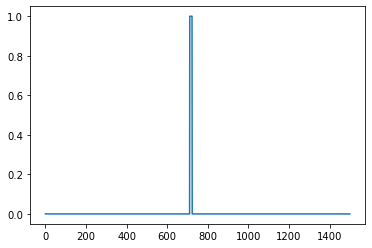

In [32]:
start_array,_ = getStartEndArrays(sub_ripples)
# first bin has artificially high number due to how start_srray workxs
start_array = start_array[:,1:] 
print(f'start array shape: {np.shape(start_array)}')

/home1/john/anaconda3/envs/workshopJ/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1389: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  norm_count = count/np.array((num_trials*binsize/1000))


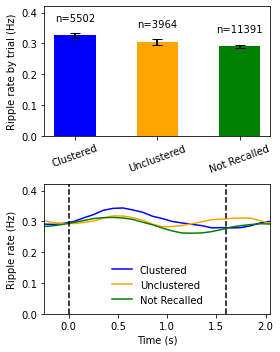

In [74]:
import matplotlib.gridspec as gridspec

# Function parameters
bin_size = 100  # in ms
smoothing_triangle = 7  # triangular smoothing window width

# bar_ylimits = (0, 0.7)
# trial_select = z_low_gamma_trials

bar_ylimits = (0, 0.42)
trial_select = ~z_low_gamma_trials

ripple_swarm_start = int((-ripple_start_offset+ripple_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_end)/sr_factor)
ripple_swarm_duration = (ripple_end-ripple_start)/1000  # convert to seconds

# Apply the clust variable to split data into clustered, unclustered, and not recalled
clust_clustered = clust > 1
clust_unclustered = clust < 0
clust_not_recalled = clust == 0

# Calculate ripple means and standard errors for each condition
mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_not_recalled = np.sum(start_array[trial_select & clust_not_recalled, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered), np.mean(mean_ripple_not_recalled)]
ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
       np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered)),
       np.std(mean_ripple_not_recalled) / np.sqrt(len(mean_ripple_not_recalled))]

# Define the palette for colors
palette = {
    'Clustered': 'blue',
    'Unclustered': 'orange',
    'Not Recalled': 'green'
}

# Set up the figure with GridSpec
fig = plt.figure(figsize=(4, 5))
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 2], width_ratios=[3, 3, 3])

# Create the bar plot with error bars (span all columns)
ax_bar = fig.add_subplot(gs[0, :])
bars = ax_bar.bar(x=['Clustered', 'Unclustered', 'Not Recalled'], 
                  height=means, 
                  color=[palette['Clustered'], palette['Unclustered'], palette['Not Recalled']], 
                  yerr=ses, 
                  width=0.5,  # Adjust width to make bars tighter
                  capsize=5, 
                  error_kw=dict(ecolor='black', elinewidth=2))

ax_bar.set_ylabel('Ripple rate by trial (Hz)')
ax_bar.set_xlabel('')
ax_bar.set_ylim(bar_ylimits)
ax_bar.set_xticklabels(['Clustered', 'Unclustered', 'Not Recalled'], rotation=20, ha="center")

# Add the number of trials above each bar
n_trials = [np.sum(trial_select & clust_clustered), 
            np.sum(trial_select & clust_unclustered), 
            np.sum(trial_select & clust_not_recalled)]
for bar, n in zip(bars, n_trials):
    ax_bar.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.04, f'n={n}', ha='center', va='bottom')

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select & clust_not_recalled], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Plot the PSTH for each group
ax_psth = fig.add_subplot(gs[1, :])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_clustered, label='Clustered', color=palette['Clustered'])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_unclustered, label='Unclustered', color=palette['Unclustered'])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_not_recalled, label='Not Recalled', color=palette['Not Recalled'])
ax_psth.axvline(x=0.0, color='black', linestyle='--')
ax_psth.axvline(x=1.6, color='black', linestyle='--')
ax_psth.set_xlabel('Time (s)')
ax_psth.set_xlim(-0.25, 2.05)
ax_psth.set_ylim(0,bar_ylimits[1])
ax_psth.set_ylabel('Ripple rate (Hz)')

# Add legend to the bottom plot
ax_psth.legend(loc='lower center', frameon=False)

# Adjust layout
plt.tight_layout()
plt.show()
a=1;

/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1389: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  norm_count = count/np.array((num_trials*binsize/1000))


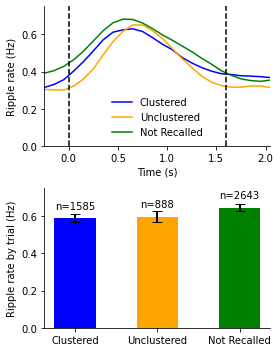

In [84]:
import matplotlib.gridspec as gridspec

# Function parameters
bin_size = 100  # in ms
smoothing_triangle = 7  # triangular smoothing window width

bar_ylimits = (0, 0.75)
trial_select = z_low_gamma_trials

# bar_ylimits = (0, 0.42)
# trial_select = ~z_low_gamma_trials

ripple_swarm_start = int((-ripple_start_offset+ripple_start)/sr_factor)
ripple_swarm_end = int((-ripple_start_offset+ripple_end)/sr_factor)
ripple_swarm_duration = (ripple_end-ripple_start)/1000  # convert to seconds

# Apply the clust variable to split data into clustered, unclustered, and not recalled
clust_clustered = clust > 1
clust_unclustered = clust < 0
clust_not_recalled = clust == 0

# Calculate ripple means and standard errors for each condition
mean_ripple_clustered = np.sum(start_array[trial_select & clust_clustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_unclustered = np.sum(start_array[trial_select & clust_unclustered, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration
mean_ripple_not_recalled = np.sum(start_array[trial_select & clust_not_recalled, ripple_swarm_start:ripple_swarm_end], axis=1) / ripple_swarm_duration

means = [np.mean(mean_ripple_clustered), np.mean(mean_ripple_unclustered), np.mean(mean_ripple_not_recalled)]
ses = [np.std(mean_ripple_clustered) / np.sqrt(len(mean_ripple_clustered)),
       np.std(mean_ripple_unclustered) / np.sqrt(len(mean_ripple_unclustered)),
       np.std(mean_ripple_not_recalled) / np.sqrt(len(mean_ripple_not_recalled))]

# Define the palette for colors
palette = {
    'Clustered': 'blue',
    'Unclustered': 'orange',
    'Not Recalled': 'green'
}

# Set up the figure with GridSpec
fig = plt.figure(figsize=(4, 5))
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 2], width_ratios=[3, 3, 3])

# Calculate PSTH for each group
ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered], bin_size, smoothing_triangle, fs, ripple_start_offset)
ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select & clust_not_recalled], bin_size, smoothing_triangle, fs, ripple_start_offset)

# Plot the PSTH for each group (move this to the top)
ax_psth = fig.add_subplot(gs[0, :])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_clustered, label='Clustered', color=palette['Clustered'])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_unclustered, label='Unclustered', color=palette['Unclustered'])
ax_psth.plot(bin_centers / 1000, ripple_PSTH_not_recalled, label='Not Recalled', color=palette['Not Recalled'])
ax_psth.axvline(x=0.0, color='black', linestyle='--')
ax_psth.axvline(x=1.6, color='black', linestyle='--')
ax_psth.set_xlabel('Time (s)')
ax_psth.set_xlim(-0.25, 2.05)
ax_psth.set_ylim(0, bar_ylimits[1])
ax_psth.set_ylabel('Ripple rate (Hz)')
ax_psth.spines['right'].set_visible(False)
ax_psth.spines['top'].set_visible(False)

# Add legend to the top plot
ax_psth.legend(loc='lower center', frameon=False)

# Create the bar plot with error bars (move this to the bottom)
ax_bar = fig.add_subplot(gs[1, :])
bars = ax_bar.bar(x=['Clustered', 'Unclustered', 'Not Recalled'], 
                  height=means, 
                  color=[palette['Clustered'], palette['Unclustered'], palette['Not Recalled']], 
                  yerr=ses, 
                  width=0.5,  # Adjust width to make bars tighter
                  capsize=5, 
                  error_kw=dict(ecolor='black', elinewidth=2))

ax_bar.set_ylabel('Ripple rate by trial (Hz)')
ax_bar.set_xlabel('')
ax_bar.set_ylim(bar_ylimits)
# ax_bar.set_xticklabels(['Clustered', 'Unclustered', 'Not Recalled'], rotation=20, ha="center")
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)

# Add the number of trials above each bar
n_trials = [np.sum(trial_select & clust_clustered), 
            np.sum(trial_select & clust_unclustered), 
            np.sum(trial_select & clust_not_recalled)]
for bar, n in zip(bars, n_trials):
    ax_bar.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.04, f'n={n}', ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show();


In [80]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Flatten the ripple data for easier modeling
ripple_data = start_array[:, ripple_swarm_start:ripple_swarm_end].sum(axis=1)

# Create a DataFrame with the data
df = pd.DataFrame({
    'ripple_rate': ripple_data,
    'clust_clustered': (clust > 1).astype(int),
    'clust_unclustered': (clust < 0).astype(int),
    'clust_not_recalled': (clust == 0).astype(int),
    'session': dd_trials['sess'],
    'subject': dd_trials['subj'],
    'low_gamma': z_low_gamma_trials
})

# Define the model formula
# 'ripple_rate ~ clust_clustered + clust_unclustered + clust_not_recalled' specifies the fixed effects
# '(1 | subject/session)' specifies the random effects, with session nested within subject
model = mixedlm(
    formula="ripple_rate ~ clust_clustered + clust_unclustered", 
    data=df, groups=df["subject"], vc_formula={"session": "0 + session"})

print(model.fit().summary())

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  ripple_rate
No. Observations:  29208    Method:              REML       
No. Groups:        6        Scale:               0.4753     
Min. group size:   216      Log-Likelihood:      -30627.5908
Max. group size:   10800    Converged:           Yes        
Mean group size:   4868.0                                   
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.423    0.028 14.927 0.000  0.367  0.478
clust_clustered    0.031    0.010  3.113 0.002  0.012  0.051
clust_unclustered -0.003    0.011 -0.297 0.767 -0.025  0.018
session Var        0.015    0.008                           



In [81]:
model = mixedlm(
    formula="ripple_rate ~ low_gamma*(clust_clustered + clust_unclustered)", 
    data=df, groups=df["subject"], vc_formula={"session": "0 + session"})

print(model.fit().summary())

                    Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        ripple_rate
No. Observations:        29208          Method:                    REML       
No. Groups:              6              Scale:                     0.4625     
Min. group size:         216            Log-Likelihood:            -30237.2777
Max. group size:         10800          Converged:                 Yes        
Mean group size:         4868.0                                               
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            0.368    0.029 12.743 0.000  0.311  0.424
low_gamma[T.True]                    0.330    0.014 23.028 0.000  0.302  0.358
clust_clustered                      0.040    0.011  3.671 0.000  0.019  

In [71]:
# Calculate PSTH for each group and for each session
sessions = np.unique(dd_trials['sess'])
session_means_clustered = []
session_means_unclustered = []
session_means_not_recalled = []

for sess in sessions:
    session_select = (dd_trials['sess'] == sess)
    ripple_PSTH_clustered, bin_centers = fullPSTH(start_array[trial_select & clust_clustered & session_select], bin_size, smoothing_triangle, fs, ripple_start_offset)
    ripple_PSTH_unclustered, _ = fullPSTH(start_array[trial_select & clust_unclustered & session_select], bin_size, smoothing_triangle, fs, ripple_start_offset)
    ripple_PSTH_not_recalled, _ = fullPSTH(start_array[trial_select & clust_not_recalled & session_select], bin_size, smoothing_triangle, fs, ripple_start_offset)
    
    session_means_clustered.append(ripple_PSTH_clustered)
    session_means_unclustered.append(ripple_PSTH_unclustered)
    session_means_not_recalled.append(ripple_PSTH_not_recalled)

# Convert lists to arrays
session_means_clustered = np.array(session_means_clustered)
session_means_unclustered = np.array(session_means_unclustered)
session_means_not_recalled = np.array(session_means_not_recalled)

# Calculate mean and SE across sessions
mean_clustered = np.mean(session_means_clustered, axis=0)
se_clustered = np.std(session_means_clustered, axis=0) / np.sqrt(len(sessions))

mean_unclustered = np.mean(session_means_unclustered, axis=0)
se_unclustered = np.std(session_means_unclustered, axis=0) / np.sqrt(len(sessions))

mean_not_recalled = np.mean(session_means_not_recalled, axis=0)
se_not_recalled = np.std(session_means_not_recalled, axis=0) / np.sqrt(len(sessions))

/home1/john/SWRrefactored/code/SWR_modules/SWRmodule.py:1389: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  norm_count = count/np.array((num_trials*binsize/1000))


In [72]:
se_clustered

array([0.04471475, 0.03687992, 0.03262109, 0.03144426, 0.03320028,
       0.03339476, 0.03309017, 0.03345545, 0.03489055, 0.03461337,
       0.03623082, 0.04001293, 0.04015411, 0.03807959, 0.03807192,
       0.03810056, 0.03646697, 0.03496168, 0.03326848, 0.03100337,
       0.02743961, 0.024039  , 0.02398981, 0.02477126, 0.02572525,
       0.02836247, 0.02995091, 0.03364906, 0.03885967, 0.046583  ])